In [40]:
import numpy as np
import pandas as pd

# ---- HÀM ĐỌC DỮ LIỆU ----
def read_data_from_excel(file_path):
    """
    Hàm đọc dữ liệu x, y từ file Excel.
    File cần có 2 cột tên là 'x' và 'y'.
    """
    try:
        df = pd.read_excel(file_path)
        if 'x' not in df.columns or 'y' not in df.columns:
            print(f"Lỗi: File Excel '{file_path}' phải chứa 2 cột có tên là 'x' và 'y'.")
            return None, None
        return df['x'].to_numpy(), df['y'].to_numpy()
    except FileNotFoundError:
        print(f"Lỗi: Không tìm thấy file '{file_path}'. Hãy đảm bảo file nằm cùng thư mục với code.")
        return None, None
    except Exception as e:
        print(f"Đã có lỗi xảy ra khi đọc file Excel: {e}")
        return None, None

# ---- CÁC HÀM CỐT LÕI DỰA TRÊN THUẬT TOÁN ----

def nhandathuc(b, c):
    """
    Nhân đa thức b(x) với (x - c) theo thuật toán bạn viết.
    Quy ước: mảng hệ số b = [b_{n-1}, b_{n-2}, ..., b_0]
    """
    n = len(b)
    a = np.zeros(n + 1)
    a[0] = b[0]
    for i in range(1, n):
        a[i] = b[i] - b[i-1] * c
    a[n] = -b[n-1] * c
    return a

def hoocneNhan(z):
    """Tính đa thức W(x) = (x-z_0)(x-z_1)..."""
    W = np.array([1.0])
    for val in z:
        W = nhandathuc(W, val)
    return W

def horner_steps(W, c):
    """
    Thực hiện lược đồ Horner và trả về một list các bước trung gian.
    """
    n = len(W) - 1
    if n < 0: return []
    
    steps = []
    b = W[0]
    steps.append(b)
    for i in range(1, n + 1):
        b = b * c + W[i]
        steps.append(b)
    return steps

def checkInput(x, y):
    """
    Loại bỏ các điểm có x trùng lặp và sắp xếp theo giá trị x.
    """
    points = {}
    for xi, yi in zip(x, y):
        if xi not in points:
            points[xi] = yi
    sorted_x = sorted(points.keys())
    sorted_y = [points[xi] for xi in sorted_x]
    return np.array(sorted_x), np.array(sorted_y)

def format_poly_final(coeffs, precision=5):
    """
    Hàm hỗ trợ in đa thức ra dạng tường minh đẹp mắt.
    """
    coeffs = np.round(coeffs, precision)
    poly_str = ""
    n = len(coeffs) - 1
    for i in range(len(coeffs)):
        coeff = coeffs[i]
        power = n - i
        if abs(coeff) < 1e-12: continue
        
        sign = " - " if coeff < 0 else " + "
        # Xử lý dấu cho số hạng đầu tiên
        if poly_str == "":
            sign = "-" if sign == " - " else ""
        
        coeff = abs(coeff)
        
        if power == 0: term = f"{coeff}"
        elif power == 1: term = f"{coeff}*x"
        else: term = f"{coeff}*x^{power}"
        
        poly_str += f"{sign}{term}"
        
    return poly_str.strip()

# ---- HÀM CHÍNH TẠO BÀI GIẢI TỔNG HỢP ----

def baiGiaiTongHop(x_data, y_data):
    """
    Thực hiện toàn bộ quá trình tính toán và in ra bài giải tổng hợp.
    """
    # Bước 1: Chuẩn bị dữ liệu và tính toán các giá trị cần thiết
    x, y = checkInput(x_data, y_data)
    n = len(x)
    
    cy_list = []
    W_matrix_for_A = []  # Ma trận chứa các đa thức W_i(x) (bậc n-1)
    final_coeffs = np.zeros(n)

    for i in range(n):
        z = np.delete(x, i)
        W = hoocneNhan(z)
        W_matrix_for_A.append(W)
        
        # Tinh(W,c) - tính giá trị của đa thức W tại x[i]
        b = W[0]
        for j in range(1, n): # W có n hệ số (bậc n-1)
            b = b * x[i] + W[j]
        c = b

        if abs(c) < 1e-12:
            print(f"Lỗi nghiêm trọng: Mẫu số tại i={i} bằng 0. Dữ liệu có thể không hợp lệ.")
            return
        
        cy_component = y[i] / c
        cy_list.append(cy_component)
        final_coeffs += cy_component * W

    # Bước 2: Chuẩn bị dữ liệu cho các bảng để in
    
    # 2.1 Bảng Tích
    tich_table = np.zeros((n, n + 2))
    W_tich = np.array([1.0])
    for i in range(n):
        tich_table[i, 0] = x[i]
        W_tich = nhandathuc(W_tich, x[i])
        num_coeffs = len(W_tich)
        start_col = (n + 1) - num_coeffs
        tich_table[i, 1 + start_col:] = W_tich
    
    # 2.2 Bảng Thương
    # Hàng header là đa thức W_{n+1}(x), có n+1 hệ số
    thuong_header = hoocneNhan(x)
    
    # Phần thân bảng là các bước Horner, mỗi hàng có n giá trị
    thuong_body_data = []
    for i in range(n):
        W_i = W_matrix_for_A[i]
        steps = horner_steps(W_i, x[i])
        
        # Thêm số 0 vào cuối để tất cả các hàng có cùng độ dài n+1
        padded_steps = steps + [0.0]
        
        thuong_body_data.append(padded_steps)

    # Ghép header và body lại
    full_thuong_table_data = [thuong_header] + thuong_body_data
    
    # Tạo nhãn cho hàng (index) và cột (columns)
    table_index = [' '] + list(np.round(x, 4))
    table_columns = [f"x^{n-j}" for j in range(n + 1)]
    
    # Tạo DataFrame cuối cùng cho Bảng Thương
    thuong_df = pd.DataFrame(full_thuong_table_data, index=table_index, columns=table_columns)

    # Bước 3: In toàn bộ báo cáo
    print("\n================== BÀI GIẢI TỔNG HỢP ==================\n")
    
    # 1. In Vector Cy
    print("1. Vector Cy:")
    print(np.array(cy_list))
    
    # Lập Bảng Tích
    print("\n2. Lập Bảng Tích:")
    tich_df = pd.DataFrame(tich_table)
    # Bỏ header và index mặc định của pandas
    print(tich_df.to_string(header=False, float_format="{:,.4f}".format))

    # 2. Lập Bảng Thương
    print("\n3. Lập bảng thương (chứa Ma trận A):")
    print(thuong_df.to_string(float_format="{:,.4f}".format))
    
    # 3. Hệ số của đa thức cuối cùng P = Cy * A
    print("\n4. Hệ số của đa thức cuối cùng P = Cy * A:")
    
    print(final_coeffs)
    
    # 4. Kết luận P(x)
    print("\n5. Kết luận P(x):")
    print(f"   P(x) = {format_poly_final(final_coeffs, precision=5)}")


# ---- CHƯƠNG TRÌNH CHÍNH ----
if __name__ == "__main__":
    file_name = "input_lagrange_moc_bat_ky.xlsx"
    x_data, y_data = read_data_from_excel(file_name)

    if x_data is not None and y_data is not None:
        # Chạy và in toàn bộ bài giải
        baiGiaiTongHop(x_data, y_data)


================== BÀI GIẢI TỔNG HỢP ==================

1. Vector Cy:
[  -967.59259267   9966.0714335  -16649.07409333  13693.33335364
  -7368.98148031    315.3659612 ]

2. Lập Bảng Tích:
0 3.5000 0.0000   0.0000   0.0000      0.0000     0.0000      1.0000    -3.5000
1 3.7000 0.0000   0.0000   0.0000      0.0000     1.0000     -7.2000    12.9500
2 3.8000 0.0000   0.0000   0.0000      1.0000   -11.0000     40.3100   -49.2100
3 4.0000 0.0000   0.0000   1.0000    -15.0000    84.3100   -210.4500   196.8400
4 4.1000 0.0000   1.0000 -19.1000    145.8100  -556.1210  1,059.6850  -807.0440
5 4.4000 1.0000 -23.5000 229.8500 -1,197.6850 3,506.6174 -5,469.6580 3,550.9936

3. Lập bảng thương (chứa Ma trận A):
                  x^6      x^5      x^4         x^3        x^2         x^1        x^0
               1.0000 -23.5000 229.8500 -1,197.6850 3,506.6174 -5,469.6580 3,550.9936
3.500000000000 1.0000 -16.5000 102.1000   -280.8600   289.8724     -0.0162     0.0000
3.700000000000 1.0000 -16.1000  97

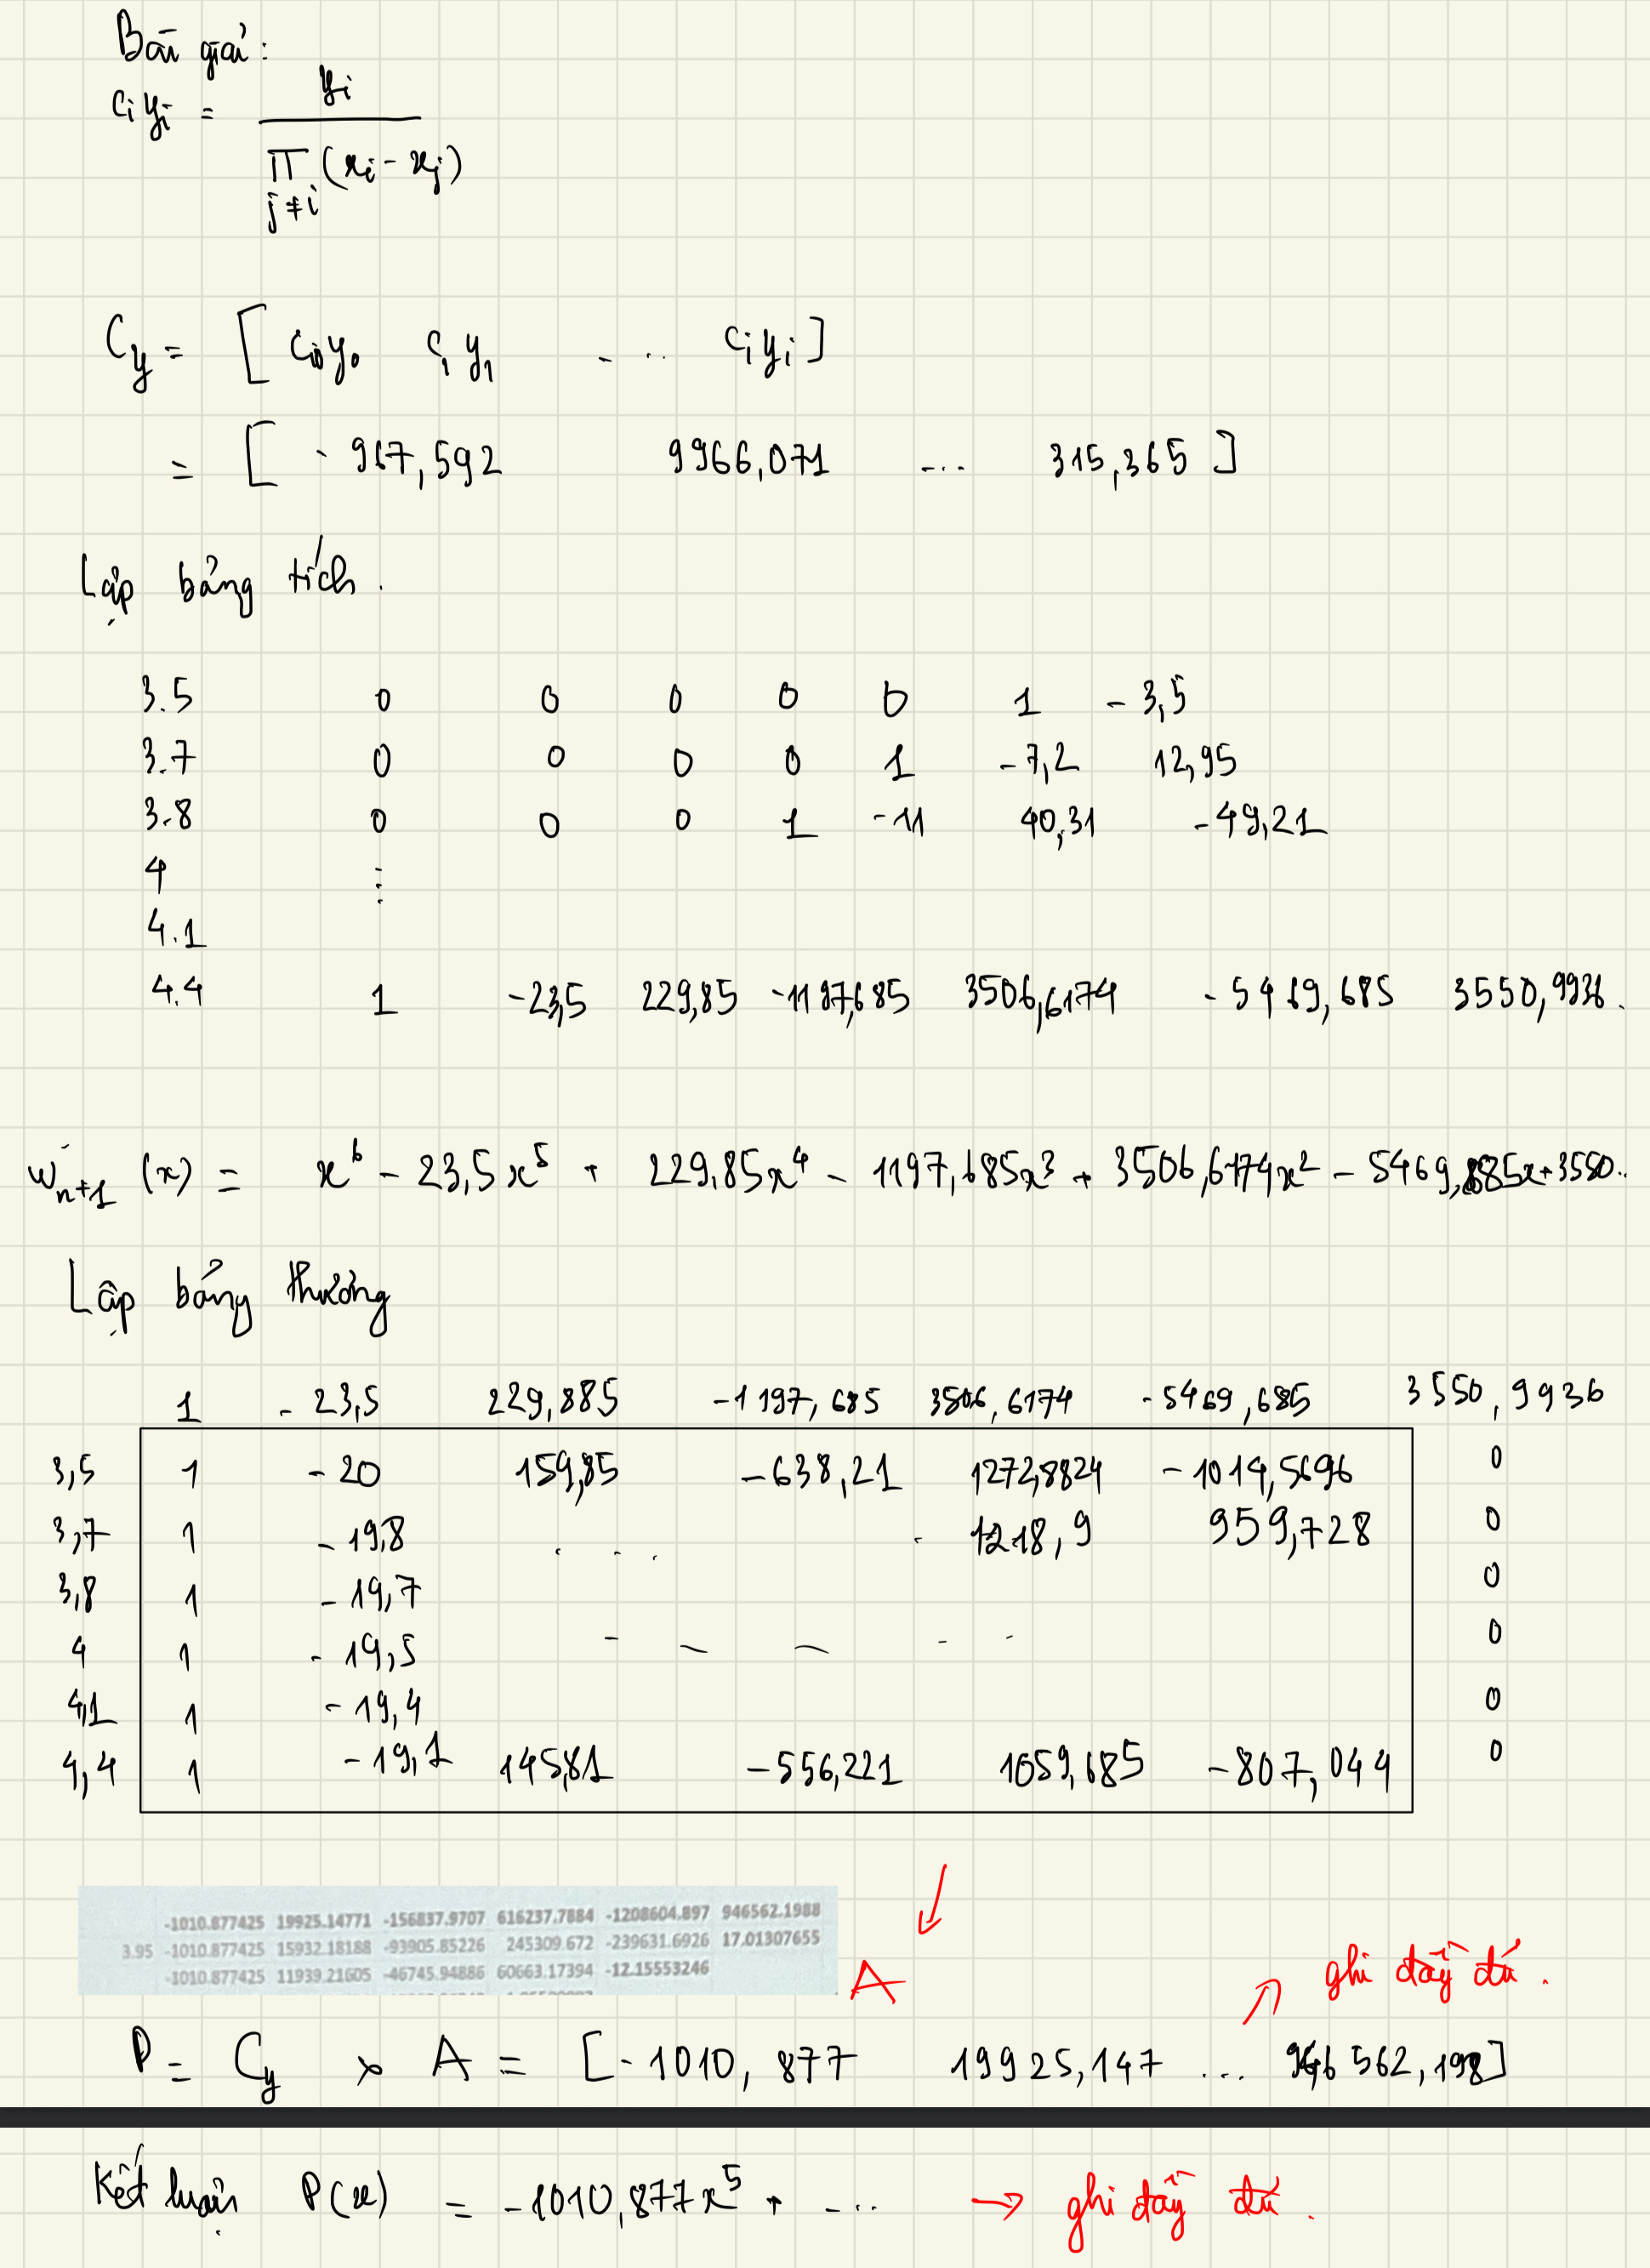
